In [1]:
#!/usr/bin/env python3
# Requires QuantLib-SWIG with modified options.i
# Copyright Prof. Jayanth R. Varma (jrvarma@iimahd.ernet.in) and 
# Prof. Vineet Virmani (vineetv@iimahd.ernet.in)

# Data for barrier option

In [2]:
from QuantLib import *
import matplotlib.pyplot as plt

barrier, barrierType, optionType, rebate = (80.0, Barrier.DownOut, Option.Call, 0.0)
underlying, strike, rf, sigma, maturity, divYield = (100, 105, 5e-2, 20e-2, 12, 0.0)
## maturity is in days and must be an integer 
barrier_data = dict( (name,eval(name)) for name in [
    'barrier', 'barrierType', 'optionType', 'rebate', 'underlying', 'strike', 
    'rf', 'sigma', 'maturity', 'divYield'] )
barrier_data['barrierType'] = ['DownIn', 'UpIn', 'DownOut', 'UpOut'][barrier_data['barrierType']]
barrier_data['optionType'] = ['Put', '???', 'Call'][barrier_data['optionType']+1]
for k in barrier_data.keys():
    print("{} = {}".format(k, barrier_data[k]))

barrier = 80.0
strike = 105
optionType = Call
divYield = 0.0
underlying = 100
rebate = 0.0
maturity = 12
barrierType = DownOut
rf = 0.05
sigma = 0.2


# Compute price of barrier option using finite difference method for different grid sizes

In [3]:
Grids = (5, 10, 25, 50, 100, 1000, 5000)
maxG = Grids[-1]

today = Settings.instance().evaluationDate
maturity_date = today + int(maturity)
process = BlackScholesMertonProcess(
    QuoteHandle(SimpleQuote(underlying)),
    YieldTermStructureHandle(FlatForward(today, divYield, Thirty360())),
    YieldTermStructureHandle(FlatForward(today, rf, Thirty360())),
    BlackVolTermStructureHandle(BlackConstantVol(
        today, NullCalendar(), sigma, Thirty360())))
option = BarrierOption(barrierType, barrier, rebate, 
                       PlainVanillaPayoff(optionType, strike), 
                       EuropeanExercise(maturity_date))
option.setPricingEngine(AnalyticBarrierEngine(process))
trueValue = option.NPV()
uErrors = []
tErrors = []
for Grid in Grids:
    option.setPricingEngine(FdBlackScholesBarrierEngine (
        process, maxG, Grid))
    uErrors.append(abs(option.NPV()/trueValue-1))
    option.setPricingEngine(FdBlackScholesBarrierEngine (
        process, Grid, maxG))
    tErrors.append(abs(option.NPV()/trueValue-1))

# Print pricing errors of finite difference method for different grid sizes

In [4]:
print("True (Analytic) Value = {:.6f}".format(trueValue))
print("{:>12}{:>12}{:>12}".format("TimeGrid", "AssetGrid", "% Error"))
for T, A, E in zip([maxG for i in Grids], Grids, uErrors):
    print("{:12}{:12}{:12.4%}".format(T, A, E))
for T, A, E in zip(Grids, [maxG for i in Grids], tErrors):
    print("{:12}{:12}{:12.4%}".format(T, A, E))

True (Analytic) Value = 0.145785
    TimeGrid   AssetGrid     % Error
        5000           5   218.5412%
        5000          10    62.0418%
        5000          25     8.8673%
        5000          50     2.0894%
        5000         100     0.4933%
        5000        1000     0.0049%
        5000        5000     0.0002%
           5        5000     0.7062%
          10        5000     0.2007%
          25        5000     0.0321%
          50        5000     0.0079%
         100        5000     0.0019%
        1000        5000     0.0002%
        5000        5000     0.0002%


# Plot pricing errors of finite difference method for different grid sizes

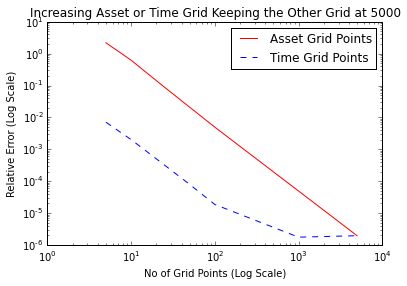

In [5]:
%matplotlib inline
plt.loglog(Grids, uErrors, 'r-', Grids, tErrors, 'b--')
plt.xlabel('No of Grid Points (Log Scale)')
plt.ylabel('Relative Error (Log Scale)')
plt.legend(['Asset Grid Points', 'Time Grid Points'])
plt.title('Increasing Asset or Time Grid Keeping the Other Grid at ' + str(maxG))
plt.show()